# <b><span style='color:#F1A424'>|</span> HMS: <span style='color:#F1A424'>Harmful Brain Activity Classification</span><span style='color:#ABABAB'> [Inference]</span></b> 

***

**Consider upvoting this notebook if you find it useful 🙌🏼**

- [Train Notebook](https://www.kaggle.com/alejopaullier/hms-efficientnetb0-pytorch-train)


Your goal in this competition is to detect and classify seizures and other types of harmful brain activity. You will develop a model trained on electroencephalography (EEG) signals recorded from critically ill hospital patients.

In this notebook you will learn how to infer with an `efficientnet` model for image classification using PyTorch. Hope you enjoy it and find it useful.

### <b><span style='color:#F1A424'>Table of Contents</span></b> <a class='anchor' id='top'></a>
<div style=" background-color:#3b3745; padding: 13px 13px; border-radius: 8px; color: white">
<li><a href="#import_libraries">Import Libraries</a></li>
<li><a href="#configuration">Configuration</a></li>
<li><a href="#utils">Utils</a></li>
<li><a href="#load_data">Load Data</a></li>
<li><a href="#dataset">Dataset</a></li>
<li><a href="#dataloader">DataLoader</a></li>
<li><a href="#model">Model</a></li>
<li><a href="#inference_function">Inference Function</a></li>
<li><a href="#infer">Infer</a></li>
<li><a href="#submission">Save Submission</a></li>
</div>

# <b><span style='color:#F1A424'>|</span> Import Libraries</b><a class='anchor' id='import_libraries'></a> [↑](#top) 

***

Import all the required libraries for this notebook.

In [1]:
%%time
# Installation of RAPIDS to Use cuSignal
import sys

!cp ../input/rapids/rapids.0.17.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
!rm /opt/conda/envs/rapids.tar.gz

sys.path += ["/opt/conda/envs/rapids/lib/python3.7/site-packages"]
sys.path += ["/opt/conda/envs/rapids/lib/python3.7"]
sys.path += ["/opt/conda/envs/rapids/lib"]
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

CPU times: user 1.22 s, sys: 239 ms, total: 1.46 s
Wall time: 1min 19s


In [2]:
import albumentations as A
import gc
import librosa
import matplotlib.pyplot as plt
import math
import multiprocessing
import numpy as np
import os
import pandas as pd
import pywt
import random
import time
import timm
import torch
import torch.nn as nn
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union
from torch import Tensor

from albumentations.pytorch import ToTensorV2
from glob import glob
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from typing import Dict, List

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using', torch.cuda.device_count(), 'GPU(s)')
import torch.nn.functional as F

import cupy as cp
import cusignal
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.signal import butter, filtfilt, iirnotch
import os
import cv2
from tqdm import tqdm

import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from scipy import signal

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using 1 GPU(s)


# <b><span style='color:#F1A424'>|</span> Configuration</b><a class='anchor' id='configuration'></a> [↑](#top) 

***

In [3]:
class config:
    BATCH_SIZE = 1
    backbone_2d = "tf_efficientnet_b0"
    NUM_WORKERS = 0 # multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SEED = 20
    VISUALIZE = False
    num_channels = 8
    pretrained = False
    augment = False
    image_transform = transforms.Resize((512,512)) 
    
class paths:
#     MODEL_WEIGHTS = "/kaggle/input/hms-multi-class-image-classification-train/tf_efficientnet_b0_epoch_3.pth"
    OUTPUT_DIR = "/kaggle/working/"
    TEST_CSV = "/kaggle/input/hms-harmful-brain-activity-classification/test.csv"
    TEST_EEGS= "/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/"
    TEST_SPECTROGRAMS = "/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/"
    
# model_weights = [x for x in glob("/kaggle/input/2d-new/v16/*.pth")]
model_weights = [f"/kaggle/input/2d-new/v17_newdata/wavenet_fold_{x}_s2_best.pth" for x in range(5)]
# model_weights.append('/kaggle/input/2d-new/v17_newdata/all_data_epoch_4.pth')
model_weights

['/kaggle/input/2d-new/v17_newdata/wavenet_fold_0_s2_best.pth',
 '/kaggle/input/2d-new/v17_newdata/wavenet_fold_1_s2_best.pth',
 '/kaggle/input/2d-new/v17_newdata/wavenet_fold_2_s2_best.pth',
 '/kaggle/input/2d-new/v17_newdata/wavenet_fold_3_s2_best.pth',
 '/kaggle/input/2d-new/v17_newdata/wavenet_fold_4_s2_best.pth']

# <b><span style='color:#F1A424'>|</span> Utils</b><a class='anchor' id='utils'></a> [↑](#top) 

***

Utility functions:
- [pywt.wavedec][1]

[1]: https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html#multilevel-decomposition-using-wavedec

In [4]:
USE_WAVELET = None 

NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

def maddest(d, axis: int = None):
    """
    Denoise function.
    """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x: np.ndarray, wavelet: str = 'haar', level: int = 1): 
    coeff = pywt.wavedec(x, wavelet, mode="per") # multilevel 1D Discrete Wavelet Transform of data.
    sigma = (1/0.6745) * maddest(coeff[-level])
    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    output = pywt.waverec(coeff, wavelet, mode='per')
    return output

def spectrogram_from_eeg(parquet_path, display=False):
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    if display:
        plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                  n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            # LOG TRANSFORM
            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            # STANDARDIZE TO -1 TO 1
            mel_spec_db = (mel_spec_db+40)/40 
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
        if display:
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
        plt.title(f'EEG {eeg_id} Signals')
        plt.show()
        print(); print('#'*25); print()
        
    return img

def plot_spectrogram(spectrogram_path: str):
    """
    Source: https://www.kaggle.com/code/mvvppp/hms-eda-and-domain-journey
    Visualize spectrogram recordings from a parquet file.
    :param spectrogram_path: path to the spectrogram parquet.
    """
    sample_spect = pd.read_parquet(spectrogram_path)
    
    split_spect = {
        "LL": sample_spect.filter(regex='^LL', axis=1),
        "RL": sample_spect.filter(regex='^RL', axis=1),
        "RP": sample_spect.filter(regex='^RP', axis=1),
        "LP": sample_spect.filter(regex='^LP', axis=1),
    }
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
    axes = axes.flatten()
    label_interval = 5
    for i, split_name in enumerate(split_spect.keys()):
        ax = axes[i]
        img = ax.imshow(np.log(split_spect[split_name]).T, cmap='viridis', aspect='auto', origin='lower')
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label('Log(Value)')
        ax.set_title(split_name)
        ax.set_ylabel("Frequency (Hz)")
        ax.set_xlabel("Time")

        ax.set_yticks(np.arange(len(split_spect[split_name].columns)))
        ax.set_yticklabels([column_name[3:] for column_name in split_spect[split_name].columns])
        frequencies = [column_name[3:] for column_name in split_spect[split_name].columns]
        ax.set_yticks(np.arange(0, len(split_spect[split_name].columns), label_interval))
        ax.set_yticklabels(frequencies[::label_interval])
    plt.tight_layout()
    plt.show()

    
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 

    
def sep():
    print("-"*100)

    
def create_spectrogram_with_cusignal(eeg_data, eeg_id, start, duration= 50,
                                    low_cut_freq = 0.7, high_cut_freq = 20, order_band = 5,
                                    spec_size_freq = 267, spec_size_time = 30,
                                    nperseg_ = 1500, noverlap_ = 1483, nfft_ = 2750,
                                    sigma_gaussian = 0.7, 
                                    mean_montage_names = 4):
    
    electrode_names = ['LL', 'RL', 'LP', 'RP']

    electrode_pairs = [
        ['Fp1', 'F7', 'T3', 'T5', 'O1'],
        ['Fp2', 'F8', 'T4', 'T6', 'O2'],
        ['Fp1', 'F3', 'C3', 'P3', 'O1'],
        ['Fp2', 'F4', 'C4', 'P4', 'O2']
    ]
    
    # Filter specifications
    nyquist_freq = 0.5 * 200
    low_cut_freq_normalized = low_cut_freq / nyquist_freq
    high_cut_freq_normalized = high_cut_freq / nyquist_freq

    # Bandpass and notch filter
    bandpass_coefficients = butter(order_band, [low_cut_freq_normalized, high_cut_freq_normalized], btype='band')
    notch_coefficients = iirnotch(w0=60, Q=30, fs=200)
    
    spec_size = duration * 200
    start = start * 200
    real_start = start + (10_000//2) - (spec_size//2)
    eeg_data = eeg_data.iloc[real_start:real_start+spec_size]
    
    
    # Spectrogram parameters
    fs = 200
    nperseg = nperseg_
    noverlap = noverlap_
    nfft = nfft_
    
    if spec_size_freq <=0 or spec_size_time <=0:
        frequencias_size = int((nfft // 2)/5.15198)+1
        segmentos = int((spec_size - noverlap) / (nperseg - noverlap)) 
    else:
        frequencias_size = spec_size_freq
        segmentos = spec_size_time
        
    spectrogram = cp.zeros((frequencias_size, segmentos, 4), dtype='float32')
    
    processed_eeg = {}

    for i, name in enumerate(electrode_names):
        cols = electrode_pairs[i]
        processed_eeg[name] = np.zeros(spec_size)
        for j in range(4):
            # Compute differential signals
            # print(cols[j])
            signal = cp.array(eeg_data[cols[j]].values - eeg_data[cols[j+1]].values)

            # Handle NaNs
            mean_signal = cp.nanmean(signal)
            signal = cp.nan_to_num(signal, nan=mean_signal) if cp.isnan(signal).mean() < 1 else cp.zeros_like(signal)
            

            # Filter bandpass and notch
            signal_filtered = filtfilt(*notch_coefficients, signal.get())
            signal_filtered = filtfilt(*bandpass_coefficients, signal_filtered)
            signal = cp.asarray(signal_filtered)
            
            frequencies, times, Sxx = cusignal.spectrogram(signal, fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)

            # Filter frequency range
            valid_freqs = (frequencies >= 0.59) & (frequencies <= 20)
            frequencies_filtered = frequencies[valid_freqs]
            Sxx_filtered = Sxx[valid_freqs, :]

            # Logarithmic transformation and normalization using Cupy
            spectrogram_slice = cp.clip(Sxx_filtered, cp.exp(-4), cp.exp(6))
            spectrogram_slice = cp.log10(spectrogram_slice)

            normalization_epsilon = 1e-6
            mean = spectrogram_slice.mean(axis=(0, 1), keepdims=True)
            std = spectrogram_slice.std(axis=(0, 1), keepdims=True)
            spectrogram_slice = (spectrogram_slice - mean) / (std + normalization_epsilon)
            
            spectrogram[:, :, i] += spectrogram_slice
            processed_eeg[f'{cols[j]}_{cols[j+1]}'] = signal.get()
            processed_eeg[name] += signal.get()
        
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        if mean_montage_names > 0:
            spectrogram[:,:,i] /= mean_montage_names

    # Convert to NumPy and apply Gaussian filter
    spectrogram_np = cp.asnumpy(spectrogram)
    if sigma_gaussian > 0.0:
        spectrogram_np = gaussian_filter(spectrogram_np, sigma=sigma_gaussian)

    # Filter EKG signal
    ekg_signal_filtered = filtfilt(*notch_coefficients, eeg_data["EKG"].values)
    ekg_signal_filtered = filtfilt(*bandpass_coefficients, ekg_signal_filtered)
    processed_eeg['EKG'] = np.array(ekg_signal_filtered)

    return spectrogram_np, processed_eeg


def create_spectogram_competition(spec_id, seconds_min):
    spec = pd.read_parquet(paths.TEST_SPECTROGRAMS + f'{spec_id}.parquet')
#     spec = pd.read_parquet('/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/' + f'{spec_id}.parquet')

    inicio = (seconds_min) // 2
    img = spec.fillna(0).values[:, 1:].T.astype("float32")
    img = img[:, inicio:inicio+300]
    
    # Log transform and normalize
    img = np.clip(img, np.exp(-4), np.exp(6))
    img = np.log(img)
    eps = 1e-6
    img_mean = img.mean()
    img_std = img.std()
    img = (img - img_mean) / (img_std + eps)
    
    return img 


def create_512_spec(eeg_data, eeg_id, spec_id, start_second = 0, seconds_min = 0):
    image_50s, _ = create_spectrogram_with_cusignal(eeg_data=eeg_data, eeg_id=eeg_id, start=start_second, duration= 50,
                                    low_cut_freq = 0.7, high_cut_freq = 20, order_band = 5,
                                    spec_size_freq = 267, spec_size_time = 501,
                                    nperseg_ = 1500, noverlap_ = 1483, nfft_ = 2750,
                                    sigma_gaussian = 0.0, 
                                    mean_montage_names = 4)
    image_10s, _ = create_spectrogram_with_cusignal(eeg_data=eeg_data, eeg_id=eeg_id, start=start_second, duration= 10,
                                    low_cut_freq = 0.7, high_cut_freq = 20, order_band = 5,
                                    spec_size_freq = 100, spec_size_time = 291,
                                    nperseg_ = 260, noverlap_ = 254, nfft_ = 1030,
                                    sigma_gaussian = 0.0, 
                                    mean_montage_names = 4)
    image_10m = create_spectogram_competition(spec_id, seconds_min)
    
    imagem_final_unico_canal = np.zeros((1068, 501))
    for j in range(4):
        inicio = j * 267 
        fim = inicio + 267
        imagem_final_unico_canal[inicio:fim, :] = image_50s[:, :, j]
        
    
    imagem_final_unico_canal2 = np.zeros((400, 291))
    for n in range(4):
        inicio = n * 100 
        fim = inicio + 100
        imagem_final_unico_canal2[inicio:fim, :] = image_10s[:, :, n]
    
    imagem_final_unico_canal_resized = cv2.resize(imagem_final_unico_canal, (400, 800), interpolation=cv2.INTER_AREA)
    imagem_final_unico_canal2_resized = cv2.resize(imagem_final_unico_canal2, (300, 400), interpolation=cv2.INTER_AREA)
    eeg_new_resized = cv2.resize(image_10m, (300, 400), interpolation=cv2.INTER_AREA)
    imagem_final = np.zeros((800, 700), dtype=np.float32)
    imagem_final[0:800, 0:400] = imagem_final_unico_canal_resized
    imagem_final[0:400,400:700] = imagem_final_unico_canal2_resized
    imagem_final[400:800, 400:700] = eeg_new_resized
    imagem_final = imagem_final[::-1]
    
    imagem_final = cv2.resize(imagem_final, (512, 512), interpolation=cv2.INTER_AREA)
    
    return imagem_final

def create_spectrogram(data):
    """This function will create the spectrograms based on the EEG data with the 'magic formula'."""
    nperseg = 150  # Length of each segment
    noverlap = 128  # Overlap between segments
    NFFT = max(256, 2 ** int(np.ceil(np.log2(nperseg))))

    # LL Spec = ( spec(Fp1 - F7) + spec(F7 - T3) + spec(T3 - T5) + spec(T5 - O1) )/4
    freqs, t,spectrum_LL1 = signal.spectrogram(data[:,feature_to_index['Fp1']]-data[:,feature_to_index['F7']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_LL2 = signal.spectrogram(data[:,feature_to_index['F7']]-data[:,feature_to_index['T3']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)

    freqs, t,spectrum_LL3 = signal.spectrogram(data[:,feature_to_index['T3']]-data[:,feature_to_index['T5']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)

    freqs, t,spectrum_LL4 = signal.spectrogram(data[:,feature_to_index['T5']]-data[:,feature_to_index['O1']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)


    LL = (spectrum_LL1+ spectrum_LL2 +spectrum_LL3 + spectrum_LL4)/4

    # LP Spec = ( spec(Fp1 - F3) + spec(F3 - C3) + spec(C3 - P3) + spec(P3 - O1) )/4
    freqs, t,spectrum_LP1 = signal.spectrogram(data[:,feature_to_index['Fp1']]-data[:,feature_to_index['F3']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)

    freqs, t,spectrum_LP2 = signal.spectrogram(data[:,feature_to_index['F3']]-data[:,feature_to_index['C3']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)

    freqs, t,spectrum_LP3 = signal.spectrogram(data[:,feature_to_index['C3']]-data[:,feature_to_index['P3']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)

    freqs, t,spectrum_LP4 = signal.spectrogram(data[:,feature_to_index['P3']]-data[:,feature_to_index['O1']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)


    LP = (spectrum_LP1+ spectrum_LP2 +spectrum_LP3 + spectrum_LP4)/4

    # RP Spec = ( spec(Fp2 - F4) + spec(F4 - C4) + spec(C4 - P4) + spec(P4 - O2) )/4
    freqs, t,spectrum_RP1 = signal.spectrogram(data[:,feature_to_index['Fp2']]-data[:,feature_to_index['F4']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)

    freqs, t,spectrum_RP2 = signal.spectrogram(data[:,feature_to_index['F4']]-data[:,feature_to_index['C4']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)

    freqs, t,spectrum_RP3 = signal.spectrogram(data[:,feature_to_index['C4']]-data[:,feature_to_index['P4']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)

    freqs, t,spectrum_RP4 = signal.spectrogram(data[:,feature_to_index['P4']]-data[:,feature_to_index['O2']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)


    RP = (spectrum_RP1+ spectrum_RP2 +spectrum_RP3 + spectrum_RP4)/4

    # RL Spec = ( spec(Fp2 - F8) + spec(F8 - T4) + spec(T4 - T6) + spec(T6 - O2) )/4
    freqs, t,spectrum_RL1 = signal.spectrogram(data[:,feature_to_index['Fp2']]-data[:,feature_to_index['F8']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)

    freqs, t,spectrum_RL2 = signal.spectrogram(data[:,feature_to_index['F8']]-data[:,feature_to_index['T4']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)

    freqs, t,spectrum_RL3 = signal.spectrogram(data[:,feature_to_index['T4']]-data[:,feature_to_index['T6']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)

    freqs, t,spectrum_RL4 = signal.spectrogram(data[:,feature_to_index['T6']]-data[:,feature_to_index['O2']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)

    RL = (spectrum_RL1+ spectrum_RL2 +spectrum_RL3 + spectrum_RL4)/4
    spectogram = np.concatenate((LL, LP,RP,RL), axis=0)
    return spectogram


label_to_num = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other':5}
num_to_label = {v: k for k, v in label_to_num.items()}
seed_everything(config.SEED)

In [5]:
def eeg_from_parquet(parquet_path: str) -> np.ndarray:
    """
    This function reads a parquet file and extracts the middle 50 seconds of readings. Then it fills NaN values
    with the mean value (ignoring NaNs).
    :param parquet_path: path to parquet file.
    :param display: whether to display EEG plots or not.
    :return data: np.array of shape  (time_steps, eeg_features) -> (10_000, 8)
    """
    # === Extract middle 50 seconds ===
    eeg = pd.read_parquet(parquet_path, columns=eeg_features)
    rows = len(eeg)
    offset = (rows - 10_000) // 2 # 50 * 200 = 10_000
    eeg = eeg.iloc[offset:offset+10_000] # middle 50 seconds, has the same amount of readings to left and right
    # === Convert to numpy ===
    data = np.zeros((10_000, len(eeg_features))) # create placeholder of same shape with zeros
    for index, feature in enumerate(eeg_features):
        x = eeg[feature].values.astype('float32') # convert to float32
        mean = np.nanmean(x) # arithmetic mean along the specified axis, ignoring NaNs
        nan_percentage = np.isnan(x).mean() # percentage of NaN values in feature
        # === Fill nan values ===
        if nan_percentage < 1: # if some values are nan, but not all
            x = np.nan_to_num(x, nan=mean)
        else: # if all values are nan
            x[:] = 0
        data[:, index] = x
   
    return data


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 
    
    
def sep():
    print("-"*100)

    
target_preds = [x + "_pred" for x in ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
label_to_num = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other':5}
num_to_label = {v: k for k, v in label_to_num.items()}
seed_everything(config.SEED)

# <b><span style='color:#F1A424'>|</span> Load Data</b><a class='anchor' id='load_data'></a> [↑](#top) 

***

Load the competition's data.

In [6]:
test_df = pd.read_csv(paths.TEST_CSV)
print(f"Test dataframe shape is: {test_df.shape}")
test_df.head()

Test dataframe shape is: (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [7]:
eeg_parquet_paths = glob(paths.TEST_EEGS + "*.parquet")
eeg_df = pd.read_parquet(eeg_parquet_paths[0])
eeg_features = eeg_df.columns
print(f'There are {len(eeg_features)} raw eeg features')
print(list(eeg_features))
# eeg_features = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
feature_to_index = {x:y for x,y in zip(eeg_features, range(len(eeg_features)))}

There are 20 raw eeg features
['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']


In [8]:
%%time

CREATE_EEGS = False
all_eegs = {}
visualize = 1
eeg_paths = glob(paths.TEST_EEGS + "*.parquet")
eeg_ids = test_df.eeg_id.unique()

for i, eeg_id in tqdm(enumerate(eeg_ids)):  
    # Save EEG to Python dictionary of numpy arrays
    eeg_path = paths.TEST_EEGS + str(eeg_id) + ".parquet"
    data = eeg_from_parquet(eeg_path)              
    all_eegs[eeg_id] = data

1it [00:00, 72.73it/s]

CPU times: user 21.4 ms, sys: 1.06 ms, total: 22.5 ms
Wall time: 18 ms


### <b><span style='color:#F1A424'>Read Spectrograms</span></b>

In [9]:
%%time

paths_spectrograms = glob(paths.TEST_SPECTROGRAMS + "*.parquet")
print(f'There are {len(paths_spectrograms)} spectrogram parquets')
all_spectrograms = {}

for file_path in tqdm(paths_spectrograms):
    aux = pd.read_parquet(file_path)
    name = int(file_path.split("/")[-1].split('.')[0])
    all_spectrograms[name] = aux.iloc[:,1:].values
    del aux
    
if config.VISUALIZE:
    idx = np.random.randint(0, len(paths_spectrograms))
    spectrogram_path = paths_spectrograms[idx]
    plot_spectrogram(spectrogram_path)

There are 1 spectrogram parquets


100%|██████████| 1/1 [00:00<00:00, 22.41it/s]

CPU times: user 42.3 ms, sys: 3.09 ms, total: 45.4 ms
Wall time: 49.8 ms


### <b><span style='color:#F1A424'>Read EEG Spectrograms</span></b>

The resulting `all_eegs` dictionary contains `eeg_id` as keys (`int` keys) and the values are the eeg sequences (as 3-dimensional `np.array`) of shape `(128, 256, 4)`.



There are 1 EEG spectrograms


  0%|          | 0/1 [00:00<?, ?it/s]

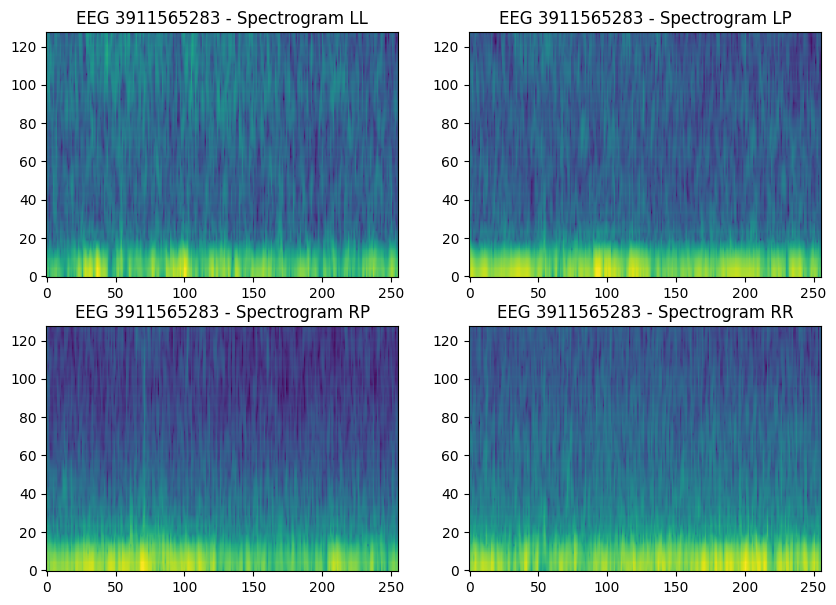

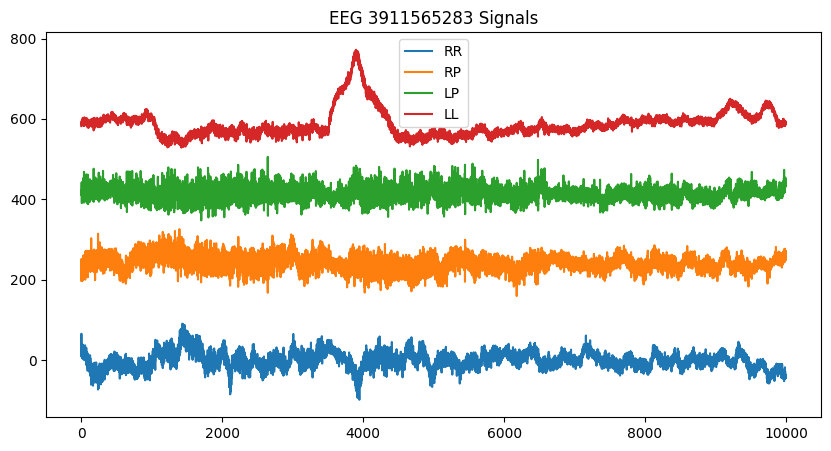

100%|██████████| 1/1 [00:10<00:00, 10.64s/it]


#########################

CPU times: user 10.7 s, sys: 1.28 s, total: 12 s
Wall time: 10.6 s


In [10]:
%%time

paths_eegs = glob(paths.TEST_EEGS + "*.parquet")
print(f'There are {len(paths_eegs)} EEG spectrograms')
all_eegs_specs = {}
counter = 0

for file_path in tqdm(paths_eegs):
    eeg_id = file_path.split("/")[-1].split(".")[0]
    eeg_spectrogram = spectrogram_from_eeg(file_path, counter < 1)
    all_eegs_specs[int(eeg_id)] = eeg_spectrogram
    counter += 1

In [11]:
%%time

all_eegs_512_spec = {}

for i in range(len(test_df)):
    row = test_df.iloc[i]
    eeg_id = row['eeg_id']
    eeg_data = pd.read_parquet(paths.TEST_EEGS + f'{eeg_id}.parquet')
    all_eegs_512_spec[str(eeg_id)] = create_512_spec(eeg_data, eeg_id, row['spectrogram_id'])

CPU times: user 23.5 s, sys: 1.79 s, total: 25.3 s
Wall time: 23.8 s


In [12]:
# plt.figure(figsize=(10, 10))
# plt.imshow(all_eegs_512_spec['3911565283'], cmap='jet')
# plt.axis('off')
# plt.show()

In [13]:
# unique
data_mean = 0.00011579196009429602
data_std = 4.5827806440634316

# <b><span style='color:#F1A424'>|</span> Dataset</b><a class='anchor' id='dataset'></a> [↑](#top) 

***

Create a custom `Dataset` to load data.

This dataloader outputs 4 spectrogram images as a 4 channel image of size 128x256x4 per train sample. This notebook version is not using data augmention but the code is available below to experiment with `albumentations` data augmention. Just add `augment = True` when creating the train data loader. And consider adding new transformations to the augment function below.

A more detailed [explanation][1] of the `r` parameter inside the `__data_generation()` method.

Our dataloader outputs both Kaggle spectrograms and EEG spectrogams as 8 channel image of size `(128, 256, 8)`

[1]: https://www.kaggle.com/code/cdeotte/efficientnetb0-starter-lb-0-43/comments#2617811

In [14]:
from scipy.signal import butter, lfilter

def butter_lowpass_filter(data, cutoff_freq: int = 20, sampling_rate: int = 200, order: int = 4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data

In [15]:
class CustomDataset(Dataset):
    def __init__(
        self, df, config, mode='train', specs=all_spectrograms, eeg_specs=all_eegs_specs, downsample=5, augment=config.augment, data_mean=data_mean, data_std=data_std
    ): 
        self.df = df
        self.config = config
        self.mode = mode
        self.spectrograms = specs
        self.eeg_spectrograms = eeg_specs
        self.downsample = downsample
        self.augment = augment
        self.USE_KAGGLE_SPECTROGRAMS = True
        self.USE_EEG_SPECTROGRAMS = True
        self.all_eegs_512_spec = all_eegs_512_spec
        self.data_mean = data_mean
        self.data_std = data_std
        
    def __len__(self):
        """
        Length of dataset.
        """
        return len(self.df)
        
    def __getitem__(self, index):
        """
        Get one item.
        """
        X1, X2, y = self.__data_generation(index)
        
        output = {
            "X1": torch.tensor(X1, dtype=torch.float32),
            "X2": torch.tensor(X2, dtype=torch.float32),
            "y": torch.tensor(y, dtype=torch.float32)
        }
        return output
    
    def get_datasetwidenorm(self, eeg_id):
        """This function will get the batch and preprocess it."""
        # Set a small epsilon to avoid division by zero
        eps = 1e-6

        # Read data from parquet file
        data = all_eegs[eeg_id]
        data = create_spectrogram(data)

        # Fill missing values with the specified constant
        mask = np.isnan(data)
        data[mask] = -1

        # Clip values and apply logarithmic transformation
        data = np.clip(data, np.exp(-6), np.exp(10))
        data = np.log(data)

        # Normalize the data
        data = (data - self.data_mean) / (self.data_std + eps)

        # Convert data to a PyTorch tensor and apply transformations
        data_tensor = torch.unsqueeze(torch.Tensor(data), dim=0)
        data = config.image_transform(data_tensor)

        # Return the batch data
        return data.numpy()
                        
    def __data_generation(self, index):
        row = self.df.iloc[index]
        
        X1, X2 = self.__spec_data_gen(row)
        
        y = np.zeros(6, dtype='float32')
        if self.mode != 'test':
            y = row[label_cols].values.astype(np.float32)
            
        return X1, X2, y
        
 
    def __spec_data_gen(self, row):
        """
        Generates spec data containing batch_size samples.
        """
#         X = np.zeros((128, 256, 8), dtype='float32')
#         img = np.ones((128,256), dtype='float32')
#         if self.mode=='test': 
#             r = 0
#         else: 
#             r = int((row['min'] + row['max']) // 4)
#         # r = int(row['spectrogram_label_offset_seconds'] // 2)

#         for region in range(4):
#             img = self.spectrograms[row.spectrogram_id][r:r+300, region*100:(region+1)*100].T

#             # Log transform spectogram
#             img = np.clip(img, np.exp(-4), np.exp(8))
#             img = np.log(img)

#             # Standarize per image
#             ep = 1e-6
#             mu = np.nanmean(img.flatten())
#             std = np.nanstd(img.flatten())
#             img = (img-mu)/(std+ep)
#             img = np.nan_to_num(img, nan=0.0)
#             X[14:-14, :, region] = img[:, 22:-22] / 2.0
#             img = self.eeg_spectrograms[row.eeg_id]
#             X[:, :, 4:] = img
            
#         # === Get spectrograms ===
#         spectrograms = np.concatenate([X[:, :, i:i+1] for i in range(4)], axis=0)

#         # === Get EEG spectrograms ===
#         eegs = np.concatenate([X[:, :, i:i+1] for i in range(4, 8)], axis=0)
        
#         X = np.concatenate([spectrograms, eegs], axis=1) #[512, 512, 1]
#         X = np.transpose(X, (2, 0, 1))
#         X = np.tile(X, (3, 1, 1))
            
        spec = self.all_eegs_512_spec[str(row['eeg_id'])]
        spec = spec[np.newaxis, :, :]
        spec = np.tile(spec, (3, 1, 1))
        
        new_norm = self.get_datasetwidenorm(row['eeg_id'])
        new_norm = np.tile(new_norm, (3, 1, 1))
        
        return spec, new_norm

# <b><span style='color:#F1A424'>|</span> DataLoader</b><a class='anchor' id='dataloader'></a> [↑](#top) 

***

Below we display example dataloader spectrogram images.

In [16]:
test_dataset = CustomDataset(test_df, config, mode="test")
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False
)
output = test_dataset[0]
X1, X2, y = output["X1"], output["X2"], output["y"]

print(f"X1 shape: {X1.shape}")
print(f"X2 shape: {X2.shape}")
print(f"y shape: {y.shape}")

X1 shape: torch.Size([3, 512, 512])
X2 shape: torch.Size([3, 512, 512])
y shape: torch.Size([6])


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


# <b><span style='color:#F1A424'>|</span> Model</b><a class='anchor' id='model'></a> [↑](#top) 

***

We will be using the [timm](https://github.com/huggingface/pytorch-image-models) library for our models.

Our models receives both Kaggle spectrograms and EEG spectrograms from our data loader. We then reshape these 8 spectrograms into 1 large flat image and feed it into EfficientNet.

In [17]:
class iAFF(nn.Module):
    '''
    多特征融合 iAFF
    '''

    def __init__(self, channels=64, r=4):
        super(iAFF, self).__init__()
        inter_channels = int(channels // r)

        # 局部注意力
        self.local_att = nn.Sequential(
            nn.Conv2d(channels, inter_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(inter_channels, channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(channels),
        )

        # 全局注意力
        self.global_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, inter_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(inter_channels, channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(channels),
        )

        # 第二次局部注意力
        self.local_att2 = nn.Sequential(
            nn.Conv2d(channels, inter_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(inter_channels, channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(channels),
        )
        # 第二次全局注意力
        self.global_att2 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, inter_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(inter_channels, channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(channels),
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x, residual):
        xa = x + residual
        xl = self.local_att(xa)
        xg = self.global_att(xa)
        xlg = xl + xg
        wei = self.sigmoid(xlg)
        xi = x * wei + residual * (1 - wei)

        xl2 = self.local_att2(xi)
        xg2 = self.global_att(xi)
        xlg2 = xl2 + xg2
        wei2 = self.sigmoid(xlg2)
        xo = x * wei2 + residual * (1 - wei2)
        return xo


In [18]:
import timm

class SpecNet(nn.Module):

    def __init__(self, backbone_2d, num_classes=6):
        super(SpecNet, self).__init__()

        # 2D efficient
        self.backbone_2d_eeg = timm.create_model(
            config.backbone_2d,
            pretrained=config.pretrained,
            drop_rate = 0.1,
            drop_path_rate = 0.1
        
        )
        self.backbone_2d_spec = timm.create_model(
            config.backbone_2d,
            pretrained=config.pretrained,
            drop_rate = 0.1,
            drop_path_rate = 0.1
        
        )
        self.features_2d_eeg = nn.Sequential(*list(self.backbone_2d_eeg.children())[:-2])
        self.features_2d_spec = nn.Sequential(*list(self.backbone_2d_spec.children())[:-2])

        # forward
        self.iaaf = iAFF(channels=1280, r=32)
        self.avg_pool_2d = nn.AdaptiveAvgPool2d(1)
        self.flatten_2d = nn.Flatten()
        self.fc1 = nn.Linear(in_features=self.backbone_2d_eeg.num_features, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        
        self.avg_pool_2d_eeg = nn.AdaptiveAvgPool2d(1)
        self.flatten_2d_eeg = nn.Flatten()
        self.fc1_eeg = nn.Linear(in_features=self.backbone_2d_eeg.num_features, out_features=128)
        self.fc2_eeg = nn.Linear(in_features=128, out_features=num_classes)
        
        self.avg_pool_2d_spec = nn.AdaptiveAvgPool2d(1)
        self.flatten_2d_spec = nn.Flatten()
        self.fc1_spec = nn.Linear(in_features=self.backbone_2d_eeg.num_features, out_features=128)
        self.fc2_spec = nn.Linear(in_features=128, out_features=num_classes)
        
        
    def reshape_input(self, x):
        """
        Reshapes input (128, 256, 8) -> 2*(3, 512, 256) monotone image.
        """ 
        # === Get spectrograms ===
        spectrograms = [x[:, :, :, i:i+1] for i in range(4)]
        spectrograms = torch.cat(spectrograms, dim=1)
        spectrograms = torch.cat([spectrograms,spectrograms,spectrograms], dim=3)
        spectrograms = spectrograms.permute(0, 3, 1, 2)
        
        # === Get EEG spectrograms ===
        eegs = [x[:, :, :, i:i+1] for i in range(4,8)]
        eegs = torch.cat(eegs, dim=1)
        eegs = torch.cat([eegs,eegs,eegs], dim=3)
        eegs = eegs.permute(0, 3, 1, 2)
        return spectrograms, eegs
    

    def forward(self, eeg, spec):
        # spec, eeg = self.reshape_input(x)
        spec_emb = self.features_2d_spec(spec) #[bs, 1280, 16, 16]
        # print(spec_emb.shape)
        eeg_emb = self.features_2d_eeg(eeg)
        
        res = self.iaaf(spec_emb, eeg_emb) #[bs, 1280, 16, 16]
        res = self.avg_pool_2d(res)
        res = self.flatten_2d(res)
        res = self.fc1(res)
        res = self.fc2(res)
        
        spec_emb = self.avg_pool_2d_spec(spec_emb)
        spec_emb = self.flatten_2d_spec(spec_emb)
        spec_emb = self.fc1_spec(spec_emb)
        res_spec = self.fc2_spec(spec_emb)
        
        eeg_emb = self.avg_pool_2d_eeg(eeg_emb)
        eeg_emb = self.flatten_2d_eeg(eeg_emb)
        eeg_emb = self.fc1_eeg(eeg_emb)
        res_eeg = self.fc2_eeg(eeg_emb)
        
        return res, res_eeg, res_spec, eeg_emb, spec_emb
    

In [19]:
model = SpecNet(config.backbone_2d)

# <b><span style='color:#F1A424'>|</span> Inference Function</b><a class='anchor' id='inference_function'></a> [↑](#top) 

***

In [20]:
def inference_function(test_loader, model, device):
    model.eval()
    softmax = nn.Softmax(dim=1)
    prediction_dict = {}
    preds = []
    with tqdm(test_loader, unit="test_batch", desc='Inference') as tqdm_test_loader:
        for step, output in enumerate(tqdm_test_loader):
            X1 = output['X1'].to(device)            
            X2 = output['X2'].to(device)
#             X_spec = X_spec.to(device)
            with torch.no_grad():
                res, res_eeg, res_spec, eeg_emb, spec_emb = model(X1, X2)
#                 y_preds = res*0.362 + res_eeg*0.326 + res_spec*0.312

                res = softmax(res)
                res_eeg = softmax(res_eeg)
                res_spec = softmax(res_spec)
            
                y_preds = res*0.359 + res_eeg*0.315 + res_spec*0.326
            preds.append(y_preds.to('cpu').numpy()) 
                
    prediction_dict["predictions"] = np.concatenate(preds) 
    return prediction_dict

# <b><span style='color:#F1A424'>|</span> Infer</b><a class='anchor' id='infer'></a> [↑](#top) 

***

In [21]:
predictions_v17_s2 = []

for model_weight in model_weights:
    print(model_weight)
    test_dataset = CustomDataset(test_df, config, mode="test")
    test_loader = DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False
    )
#     model = CustomModel(config)
    checkpoint = torch.load(model_weight)
    model.load_state_dict(checkpoint["model"])
    model.to(device)
    prediction_dict = inference_function(test_loader, model, device)
    predictions_v17_s2.append(prediction_dict["predictions"])
    torch.cuda.empty_cache()
    gc.collect()
    
predictions_v17_s2 = np.array(predictions_v17_s2)
predictions_v17_s2 = np.mean(predictions_v17_s2, axis=0)

/kaggle/input/2d-new/v17_newdata/wavenet_fold_0_s2_best.pth


Inference: 100%|██████████| 1/1 [00:00<00:00,  1.28test_batch/s]


/kaggle/input/2d-new/v17_newdata/wavenet_fold_1_s2_best.pth


Inference: 100%|██████████| 1/1 [00:00<00:00, 14.71test_batch/s]


/kaggle/input/2d-new/v17_newdata/wavenet_fold_2_s2_best.pth


Inference: 100%|██████████| 1/1 [00:00<00:00, 14.93test_batch/s]


/kaggle/input/2d-new/v17_newdata/wavenet_fold_3_s2_best.pth


Inference: 100%|██████████| 1/1 [00:00<00:00, 16.03test_batch/s]


/kaggle/input/2d-new/v17_newdata/wavenet_fold_4_s2_best.pth


Inference: 100%|██████████| 1/1 [00:00<00:00, 16.57test_batch/s]


# v16 s2

In [22]:
model_weights = [f"/kaggle/input/2d-new/v16_newdata/wavenet_fold_{x}_s2_best.pth" for x in range(5)]
# model_weights.append('/kaggle/input/2d-new/v16_newdata/all_data_epoch_4.pth')
model_weights

['/kaggle/input/2d-new/v16_newdata/wavenet_fold_0_s2_best.pth',
 '/kaggle/input/2d-new/v16_newdata/wavenet_fold_1_s2_best.pth',
 '/kaggle/input/2d-new/v16_newdata/wavenet_fold_2_s2_best.pth',
 '/kaggle/input/2d-new/v16_newdata/wavenet_fold_3_s2_best.pth',
 '/kaggle/input/2d-new/v16_newdata/wavenet_fold_4_s2_best.pth']

In [23]:
class CustomDataset(Dataset):
    def __init__(
        self, df, config, mode='train', specs=all_spectrograms, eeg_specs=all_eegs_specs, downsample=5, augment=config.augment, data_mean=data_mean, data_std=data_std
    ): 
        self.df = df
        self.config = config
        self.mode = mode
        self.spectrograms = specs
        self.eeg_spectrograms = eeg_specs
        self.downsample = downsample
        self.augment = augment
        self.USE_KAGGLE_SPECTROGRAMS = True
        self.USE_EEG_SPECTROGRAMS = True
        self.all_eegs_512_spec = all_eegs_512_spec
        self.data_mean = data_mean
        self.data_std = data_std
        
    def __len__(self):
        """
        Length of dataset.
        """
        return len(self.df)
        
    def __getitem__(self, index):
        """
        Get one item.
        """
        X1, X2, y = self.__data_generation(index)
        
        # if self.augment and self.mode == 'train':
        #     X_spec = self.__transform(X_spec) 
        
        output = {
            "X1": torch.tensor(X1, dtype=torch.float32),
            "X2": torch.tensor(X2, dtype=torch.float32),
            "y": torch.tensor(y, dtype=torch.float32)
        }
        return output
    
    def get_datasetwidenorm(self, eeg_id):
        """This function will get the batch and preprocess it."""
        # Set a small epsilon to avoid division by zero
        eps = 1e-6

        # Read data from parquet file
        data = all_eegs[eeg_id]
        data = create_spectrogram(data)

        # Fill missing values with the specified constant
        mask = np.isnan(data)
        data[mask] = -1

        # Clip values and apply logarithmic transformation
        data = np.clip(data, np.exp(-6), np.exp(10))
        data = np.log(data)

        # Normalize the data
        data = (data - self.data_mean) / (self.data_std + eps)

        # Convert data to a PyTorch tensor and apply transformations
        data_tensor = torch.unsqueeze(torch.Tensor(data), dim=0)
        data = config.image_transform(data_tensor)

        # Return the batch data
        return data.numpy()
                        
    def __data_generation(self, index):
        row = self.df.iloc[index]
        
        X1, X2 = self.__spec_data_gen(row)
        
        y = np.zeros(6, dtype='float32')
        if self.mode != 'test':
            y = row[label_cols].values.astype(np.float32)
            
        return X1, X2, y
        
 
    def __spec_data_gen(self, row):
        """
        Generates spec data containing batch_size samples.
        """
        X = np.zeros((128, 256, 8), dtype='float32')
        img = np.ones((128,256), dtype='float32')
        if self.mode=='test': 
            r = 0
        else: 
            r = int((row['min'] + row['max']) // 4)
        # r = int(row['spectrogram_label_offset_seconds'] // 2)

        for region in range(4):
            img = self.spectrograms[row.spectrogram_id][r:r+300, region*100:(region+1)*100].T

            # Log transform spectogram
            img = np.clip(img, np.exp(-4), np.exp(8))
            img = np.log(img)

            # Standarize per image
            ep = 1e-6
            mu = np.nanmean(img.flatten())
            std = np.nanstd(img.flatten())
            img = (img-mu)/(std+ep)
            img = np.nan_to_num(img, nan=0.0)
            X[14:-14, :, region] = img[:, 22:-22] / 2.0
            img = self.eeg_spectrograms[row.eeg_id]
            X[:, :, 4:] = img
            
        # === Get spectrograms ===
        spectrograms = np.concatenate([X[:, :, i:i+1] for i in range(4)], axis=0)

        # === Get EEG spectrograms ===
        eegs = np.concatenate([X[:, :, i:i+1] for i in range(4, 8)], axis=0)
        
        X = np.concatenate([spectrograms, eegs], axis=1) #[512, 512, 1]
        X = np.transpose(X, (2, 0, 1))
        X = np.tile(X, (3, 1, 1))
            
#         spec = self.all_eegs_512_spec[str(row['eeg_id'])]
#         spec = spec[np.newaxis, :, :]
#         spec = np.tile(spec, (3, 1, 1))
        
        new_norm = self.get_datasetwidenorm(row['eeg_id'])
        new_norm = np.tile(new_norm, (3, 1, 1))
        
        return X, new_norm
    
    def __transform(self, img):
        fill_value = tuple(range(img.shape[-1]))
        params1 = {
                    "num_masks_x": 1,    
                    "mask_x_length": (0, 20), # This line changed from fixed  to a range
                    "fill_value": fill_value,
                    }
        params2 = {    
                    "num_masks_y": 1,    
                    "mask_y_length": (0, 20),
                    "fill_value": fill_value,
                    }
        params3 = {    
                    "num_masks_x": (2, 4),
                    "num_masks_y": 5,    
                    "mask_y_length": 8,
                    "mask_x_length": (10, 20),
                    "fill_value": fill_value,
                    }
        
        transforms = A.Compose([
            # A.XYMasking(**params1, p=0.5),
            # A.XYMasking(**params2, p=0.5),
            # A.XYMasking(**params3, p=0.5),
            # A.RandomRotate90(),
            # A.VerticalFlip(p=0.5),
            # A.HorizontalFlip(),
            A.MixUp(reference_data=self.df.index.to_list(), read_fn=self.read_fn, alpha=1, p=0.5)
        ])
        return transforms(image=img)['image']

    
    def read_fn(self, index):
        row = self.df.iloc[index]
        img = self.__spec_data_gen(row)

        # img = normalize_image(img)
        
        global_label = row[label_cols].values.astype(np.float32)

        return {"image": img, "global_label": global_label}

In [24]:
def inference_function(test_loader, model, device):
    model.eval()
    softmax = nn.Softmax(dim=1)
    prediction_dict = {}
    preds = []
    with tqdm(test_loader, unit="test_batch", desc='Inference') as tqdm_test_loader:
        for step, output in enumerate(tqdm_test_loader):
            X1 = output['X1'].to(device)            
            X2 = output['X2'].to(device)
#             X_spec = X_spec.to(device)
            with torch.no_grad():
                res, res_eeg, res_spec, eeg_emb, spec_emb = model(X1, X2)
#                 y_preds = res*0.362 + res_eeg*0.326 + res_spec*0.312

                res = softmax(res)
                res_eeg = softmax(res_eeg)
                res_spec = softmax(res_spec)
            
                y_preds = res*0.356 + res_eeg*0.31 + res_spec*0.334
            preds.append(y_preds.to('cpu').numpy()) 
                
    prediction_dict["predictions"] = np.concatenate(preds) 
    return prediction_dict

In [25]:
predictions_v16_s2 = []

for model_weight in model_weights:
    test_dataset = CustomDataset(test_df, config, mode="test")
    test_loader = DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False
    )
#     model = CustomModel(config)
    checkpoint = torch.load(model_weight)
    model.load_state_dict(checkpoint["model"])
    model.to(device)
    prediction_dict = inference_function(test_loader, model, device)
    predictions_v16_s2.append(prediction_dict["predictions"])
    torch.cuda.empty_cache()
    gc.collect()
    
predictions_v16_s2 = np.array(predictions_v16_s2)
predictions_v16_s2 = np.mean(predictions_v16_s2, axis=0)

Inference: 100%|██████████| 1/1 [00:00<00:00, 14.12test_batch/s]


# v12 s2

In [26]:
model_weights = [f"/kaggle/input/2d-new/v12_newdata/wavenet_fold_{x}_s2_best.pth" for x in range(5)]
# model_weights.append('/kaggle/input/2d-new/v12_newdata/all_data_epoch_4.pth')
model_weights

['/kaggle/input/2d-new/v12_newdata/wavenet_fold_0_s2_best.pth',
 '/kaggle/input/2d-new/v12_newdata/wavenet_fold_1_s2_best.pth',
 '/kaggle/input/2d-new/v12_newdata/wavenet_fold_2_s2_best.pth',
 '/kaggle/input/2d-new/v12_newdata/wavenet_fold_3_s2_best.pth',
 '/kaggle/input/2d-new/v12_newdata/wavenet_fold_4_s2_best.pth']

In [27]:
class CustomDataset(Dataset):
    def __init__(
        self, df, config, mode='train', specs=all_spectrograms, eeg_specs=all_eegs_specs, downsample=5, augment=config.augment, data_mean=data_mean, data_std=data_std
    ): 
        self.df = df
        self.config = config
        self.mode = mode
        self.spectrograms = specs
        self.eeg_spectrograms = eeg_specs
        self.downsample = downsample
        self.augment = augment
        self.USE_KAGGLE_SPECTROGRAMS = True
        self.USE_EEG_SPECTROGRAMS = True
        self.all_eegs_512_spec = all_eegs_512_spec
        self.data_mean = data_mean
        self.data_std = data_std
        
    def __len__(self):
        """
        Length of dataset.
        """
        return len(self.df)
        
    def __getitem__(self, index):
        """
        Get one item.
        """
        X1, X2, y = self.__data_generation(index)
        
        # if self.augment and self.mode == 'train':
        #     X_spec = self.__transform(X_spec) 
        
        output = {
            "X1": torch.tensor(X1, dtype=torch.float32),
            "X2": torch.tensor(X2, dtype=torch.float32),
            "y": torch.tensor(y, dtype=torch.float32)
        }
        return output
    
    def get_datasetwidenorm(self, eeg_id):
        """This function will get the batch and preprocess it."""
        # Set a small epsilon to avoid division by zero
        eps = 1e-6

        # Read data from parquet file
        data = all_eegs[eeg_id]
        data = create_spectrogram(data)

        # Fill missing values with the specified constant
        mask = np.isnan(data)
        data[mask] = -1

        # Clip values and apply logarithmic transformation
        data = np.clip(data, np.exp(-6), np.exp(10))
        data = np.log(data)

        # Normalize the data
        data = (data - self.data_mean) / (self.data_std + eps)

        # Convert data to a PyTorch tensor and apply transformations
        data_tensor = torch.unsqueeze(torch.Tensor(data), dim=0)
        data = config.image_transform(data_tensor)

        # Return the batch data
        return data.numpy()
                        
    def __data_generation(self, index):
        row = self.df.iloc[index]
        
        X1, X2 = self.__spec_data_gen(row)
        
        y = np.zeros(6, dtype='float32')
        if self.mode != 'test':
            y = row[label_cols].values.astype(np.float32)
            
        return X1, X2, y
        
 
    def __spec_data_gen(self, row):
        """
        Generates spec data containing batch_size samples.
        """
        X = np.zeros((128, 256, 8), dtype='float32')
        img = np.ones((128,256), dtype='float32')
        if self.mode=='test': 
            r = 0
        else: 
            r = int((row['min'] + row['max']) // 4)
        # r = int(row['spectrogram_label_offset_seconds'] // 2)

        for region in range(4):
            img = self.spectrograms[row.spectrogram_id][r:r+300, region*100:(region+1)*100].T

            # Log transform spectogram
            img = np.clip(img, np.exp(-4), np.exp(8))
            img = np.log(img)

            # Standarize per image
            ep = 1e-6
            mu = np.nanmean(img.flatten())
            std = np.nanstd(img.flatten())
            img = (img-mu)/(std+ep)
            img = np.nan_to_num(img, nan=0.0)
            X[14:-14, :, region] = img[:, 22:-22] / 2.0
            img = self.eeg_spectrograms[row.eeg_id]
            X[:, :, 4:] = img
            
        # === Get spectrograms ===
        spectrograms = np.concatenate([X[:, :, i:i+1] for i in range(4)], axis=0)

        # === Get EEG spectrograms ===
        eegs = np.concatenate([X[:, :, i:i+1] for i in range(4, 8)], axis=0)
        
        X = np.concatenate([spectrograms, eegs], axis=1) #[512, 512, 1]
        X = np.transpose(X, (2, 0, 1))
        X = np.tile(X, (3, 1, 1))
            
        spec = self.all_eegs_512_spec[str(row['eeg_id'])]
        spec = spec[np.newaxis, :, :]
        spec = np.tile(spec, (3, 1, 1))
        
#         new_norm = self.get_datasetwidenorm(row['eeg_id'])
#         new_norm = np.tile(new_norm, (3, 1, 1))
        
        return X, spec
    
    def __transform(self, img):
        fill_value = tuple(range(img.shape[-1]))
        params1 = {
                    "num_masks_x": 1,    
                    "mask_x_length": (0, 20), # This line changed from fixed  to a range
                    "fill_value": fill_value,
                    }
        params2 = {    
                    "num_masks_y": 1,    
                    "mask_y_length": (0, 20),
                    "fill_value": fill_value,
                    }
        params3 = {    
                    "num_masks_x": (2, 4),
                    "num_masks_y": 5,    
                    "mask_y_length": 8,
                    "mask_x_length": (10, 20),
                    "fill_value": fill_value,
                    }
        
        transforms = A.Compose([
            # A.XYMasking(**params1, p=0.5),
            # A.XYMasking(**params2, p=0.5),
            # A.XYMasking(**params3, p=0.5),
            # A.RandomRotate90(),
            # A.VerticalFlip(p=0.5),
            # A.HorizontalFlip(),
            A.MixUp(reference_data=self.df.index.to_list(), read_fn=self.read_fn, alpha=1, p=0.5)
        ])
        return transforms(image=img)['image']

    
    def read_fn(self, index):
        row = self.df.iloc[index]
        img = self.__spec_data_gen(row)

        # img = normalize_image(img)
        
        global_label = row[label_cols].values.astype(np.float32)

        return {"image": img, "global_label": global_label}

In [28]:
def inference_function(test_loader, model, device):
    model.eval()
    softmax = nn.Softmax(dim=1)
    prediction_dict = {}
    preds = []
    with tqdm(test_loader, unit="test_batch", desc='Inference') as tqdm_test_loader:
        for step, output in enumerate(tqdm_test_loader):
            X1 = output['X1'].to(device)            
            X2 = output['X2'].to(device)
#             X_spec = X_spec.to(device)
            with torch.no_grad():
                res, res_eeg, res_spec, eeg_emb, spec_emb = model(X1, X2)
#                 y_preds = res*0.362 + res_eeg*0.326 + res_spec*0.312

                res = softmax(res)
                res_eeg = softmax(res_eeg)
                res_spec = softmax(res_spec)
            
                y_preds = res*0.35 + res_eeg*0.323 + res_spec*0.327
            preds.append(y_preds.to('cpu').numpy()) 
                
    prediction_dict["predictions"] = np.concatenate(preds) 
    return prediction_dict

In [29]:
predictions_v12_s2 = []

for model_weight in model_weights:
    test_dataset = CustomDataset(test_df, config, mode="test")
    test_loader = DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False
    )
#     model = CustomModel(config)
    checkpoint = torch.load(model_weight)
    model.load_state_dict(checkpoint["model"])
    model.to(device)
    prediction_dict = inference_function(test_loader, model, device)
    predictions_v12_s2.append(prediction_dict["predictions"])
    torch.cuda.empty_cache()
    gc.collect()
    
predictions_v12_s2 = np.array(predictions_v12_s2)
predictions_v12_s2 = np.mean(predictions_v12_s2, axis=0)

Inference: 100%|██████████| 1/1 [00:00<00:00, 29.43test_batch/s]


# v70 s2

In [30]:
model_weights = [x for x in glob("/kaggle/input/1d-2d-new/v70_newdata_re/*.pth")]
model_weights

['/kaggle/input/1d-2d-new/v70_newdata_re/wavenet_fold_4_best_s2.pth',
 '/kaggle/input/1d-2d-new/v70_newdata_re/wavenet_fold_0_best_s2.pth',
 '/kaggle/input/1d-2d-new/v70_newdata_re/wavenet_fold_3_best_s2.pth',
 '/kaggle/input/1d-2d-new/v70_newdata_re/wavenet_fold_1_best_s2.pth',
 '/kaggle/input/1d-2d-new/v70_newdata_re/wavenet_fold_2_best_s2.pth']

In [31]:
def eeg_from_parquet(parquet_path: str) -> np.ndarray:
    """
    This function reads a parquet file and extracts the middle 50 seconds of readings. Then it fills NaN values
    with the mean value (ignoring NaNs).
    :param parquet_path: path to parquet file.
    :param display: whether to display EEG plots or not.
    :return data: np.array of shape  (time_steps, eeg_features) -> (10_000, 8)
    """
    # === Extract middle 50 seconds ===
    eeg = pd.read_parquet(parquet_path, columns=eeg_features)
    rows = len(eeg)
    offset = (rows - 10_000) // 2 # 50 * 200 = 10_000
    eeg = eeg.iloc[offset:offset+10_000] # middle 50 seconds, has the same amount of readings to left and right
    # === Convert to numpy ===
    data = np.zeros((10_000, len(eeg_features))) # create placeholder of same shape with zeros
    for index, feature in enumerate(eeg_features):
        x = eeg[feature].values.astype('float32') # convert to float32
        mean = np.nanmean(x) # arithmetic mean along the specified axis, ignoring NaNs
        nan_percentage = np.isnan(x).mean() # percentage of NaN values in feature
        # === Fill nan values ===
        if nan_percentage < 1: # if some values are nan, but not all
            x = np.nan_to_num(x, nan=mean)
        else: # if all values are nan
            x[:] = 0
        data[:, index] = x
   
    return data


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 
    
    
def sep():
    print("-"*100)

    
target_preds = [x + "_pred" for x in ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
label_to_num = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other':5}
num_to_label = {v: k for k, v in label_to_num.items()}
seed_everything(config.SEED)

In [32]:
class CustomDataset(Dataset):
    def __init__(
        self, df, config, mode='test', eegs=all_eegs, specs=all_spectrograms, eeg_specs=all_eegs_specs, downsample=5, data_mean=data_mean, data_std=data_std
    ): 
        self.df = df
        self.config = config
        self.mode = mode
        self.eegs = eegs
        self.spectrograms = specs
        self.eeg_spectrograms = eeg_specs
        self.all_eegs_512_spec = all_eegs_512_spec
        self.downsample = downsample
        self.data_mean = data_mean
        self.data_std = data_std
        
    def __len__(self):
        """
        Length of dataset.
        """
        return len(self.df)
        
    def __getitem__(self, index):
        """
        Get one item.
        """
        X_eeg, X_spec, y = self.__data_generation(index)
            
            
        # X_eeg = X_eeg[::self.downsample,:]
        output = {
            "X_eeg": torch.tensor(X_eeg, dtype=torch.float32),
            "X_spec": torch.tensor(X_spec, dtype=torch.float32),
            "y": torch.tensor(y, dtype=torch.float32)
        }
        return output
                        
    def __data_generation(self, index):
        row = self.df.iloc[index]
        
        X_eeg = self.__eeg_data_gen(row)
        X_spec = self.__spec_data_gen(row)
        
        y = np.zeros(6, dtype='float32')
        if self.mode != 'test':
            y = row[label_cols].values.astype(np.float32)
            
        return X_eeg, X_spec, y
        
    def resize_func(self, x, target_size=10000, use_percentile_feat=False):
        ch = x.shape[0] 
        input_size = x.shape[1]
        pad = target_size - input_size % target_size
        factor = (input_size + pad) / input_size
        x = np.array([ndi.zoom(xi, zoom=factor, mode='reflect') for xi in x])
        x = x.reshape((ch, target_size, -1))
        res = {} 
        res['mean'] = np.mean(x, axis=2).reshape(-1, ch)
        res['max'] = np.max(x, axis=2).reshape(-1, ch)
        res['min'] = np.min(x, axis=2).reshape(-1, ch)
        res['med'] = np.median(x, axis=2).reshape(-1, ch)
        res['std'] = np.sqrt(np.var(x, axis=2).reshape(-1, ch))
        if use_percentile_feat:
           for p in [15, 30, 45, 60, 75, 90]:
               res[f"p{p}"] = np.percentile(x, [p], axis=2).reshape(-1, ch)
        return res

    def get_datasetwidenorm(self, eeg_id):
        """This function will get the batch and preprocess it."""
        # Set a small epsilon to avoid division by zero
        eps = 1e-6

        # Read data from parquet file
        data = all_eegs[eeg_id]
        data = create_spectrogram(data)

        # Fill missing values with the specified constant
        mask = np.isnan(data)
        data[mask] = -1

        # Clip values and apply logarithmic transformation
        data = np.clip(data, np.exp(-6), np.exp(10))
        data = np.log(data)

        # Normalize the data
        data = (data - self.data_mean) / (self.data_std + eps)

        # Convert data to a PyTorch tensor and apply transformations
        data_tensor = torch.unsqueeze(torch.Tensor(data), dim=0)
        data = config.image_transform(data_tensor)

        # Return the batch data
        return data.numpy()
    
    def __eeg_data_gen(self, row):
        X = np.zeros((10_000, 8), dtype='float32')
        data = self.eegs[row.eeg_id]
        
        # === Feature engineering ===
        X[:,0] = data[:,feature_to_index['Fp1']] - data[:,feature_to_index['T3']]
        X[:,1] = data[:,feature_to_index['T3']] - data[:,feature_to_index['O1']]

        X[:,2] = data[:,feature_to_index['Fp1']] - data[:,feature_to_index['C3']]
        X[:,3] = data[:,feature_to_index['C3']] - data[:,feature_to_index['O1']]

        X[:,4] = data[:,feature_to_index['Fp2']] - data[:,feature_to_index['C4']]
        X[:,5] = data[:,feature_to_index['C4']] - data[:,feature_to_index['O2']]

        X[:,6] = data[:,feature_to_index['Fp2']] - data[:,feature_to_index['T4']]
        X[:,7] = data[:,feature_to_index['T4']] - data[:,feature_to_index['O2']]


        # if config.filter_signal:
        #     diff_feat = butter_bandpass_filter(
        #         diff_feat, config.lowcut, config.highcut, config.sampling_rate, order=config.filter_order
        #     )

        # if self.mode != "test" and random.uniform(0.0, 1.0) <= 0.1:
        #     lowcut = random.randint(10, 25)  # random.uniform(1.0, 25.0)
        #     highcut = lowcut + 1.0  # random.uniform(0.0, 0.01)
        #     diff_feat = butter_bandpass_filter(
        #         diff_feat, lowcut, highcut, config.sampling_rate, order=config.filter_order  # 6
        #     )
        
        # new_feas_dict = self.resize_func(np.transpose(data, (1, 0)))
        # # print(new_feas_dict['mean'].shape)
        # for key, value in new_feas_dict.items():
        #     X = np.concatenate([X, value], axis=1)
        
        # === Standarize ===
        X = np.clip(X,-1024, 1024)
        X = np.nan_to_num(X, nan=0) / 32.0

        # === Butter Low-pass Filter ===
        X = butter_lowpass_filter(X)
        # X = quantize_data(X, 1)
        
        return X
    
    def __spec_data_gen(self, row):
        """
        Generates spec data containing batch_size samples.
        """
        # eeg_id = row['eeg_id']
        # X = self.all_eegs_512_spec[str(eeg_id)]
        X = np.zeros((128, 256, 8), dtype='float32')
        img = np.ones((128,256), dtype='float32')
        if self.mode=='test': 
            r = 0
        else: 
            r = int((row['min'] + row['max']) // 4)
            # r = int(row['spectrogram_label_offset_seconds'] // 2)
            
        for region in range(4):
            img = self.spectrograms[row.spectrogram_id][r:r+300, region*100:(region+1)*100].T
            
            # Log transform spectogram
            img = np.clip(img, np.exp(-4), np.exp(8))
            img = np.log(img)

            # Standarize per image
            ep = 1e-6
            mu = np.nanmean(img.flatten())
            std = np.nanstd(img.flatten())
            img = (img-mu)/(std+ep)
            img = np.nan_to_num(img, nan=0.0)
            X[14:-14, :, region] = img[:, 22:-22] / 2.0
            img = self.eeg_spectrograms[row.eeg_id]
            X[:, :, 4:] = img
        
        # === Get spectrograms ===
        spectrograms = np.concatenate([X[:, :, i:i+1] for i in range(4)], axis=0)
        
        # === Get EEG spectrograms ===
        eegs = np.concatenate([X[:, :, i:i+1] for i in range(4, 8)], axis=0)
        
        X = np.concatenate([spectrograms, eegs], axis=1) #[512, 512, 1]
        X = np.transpose(X, (2, 0, 1))

        spec = self.all_eegs_512_spec[str(row['eeg_id'])]
        spec = spec[np.newaxis, :, :]
        
        new_norm = self.get_datasetwidenorm(row['eeg_id'])
        # print(new_norm.shape)
        
        # # v54 [3, 1536, 512]
        # X = np.concatenate([X, spec, spec], axis=1)
        # X = np.tile(X, (3, 1, 1))
        
        # # v53 [3, 512, 512]
        # X = np.concatenate([X, spec, spec], axis=0)
        
        # # v55 [3, 1024, 512]
        # X = np.concatenate([X, spec], axis=1)
        # X = np.tile(X, (3, 1, 1))
        
        # # v66 [3, 512, 1536]
        # X = np.concatenate([X, X, spec], axis=1)
        # X = np.tile(X, (3, 1, 1))
        
        # # v67
        # X = np.concatenate([spectrograms, eegs, spec], axis=0)
        
        # # v68
        # X = np.concatenate([X, spec, new_norm], axis=0)
        
        # v69
        X = np.concatenate([X, spec, new_norm], axis=1)
        X = np.tile(X, (3, 1, 1))
        
        return X

In [33]:
class iAFF(nn.Module):
    '''
    多特征融合 iAFF
    '''

    def __init__(self, channels=6, r=2):
        super(iAFF, self).__init__()
        inter_channels = int(channels // r)

        # 局部注意力
        self.local_att = nn.Sequential(
            nn.Conv1d(channels, inter_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm1d(inter_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(inter_channels, channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm1d(channels),
        )

        # 全局注意力
        self.global_att = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(channels, inter_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm1d(inter_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(inter_channels, channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm1d(channels),
        )

        # 第二次局部注意力
        self.local_att2 = nn.Sequential(
            nn.Conv1d(channels, inter_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm1d(inter_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(inter_channels, channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm1d(channels),
        )
        # 第二次全局注意力
        self.global_att2 = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(channels, inter_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm1d(inter_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(inter_channels, channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm1d(channels),
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x, residual):
        xa = x + residual
        xl = self.local_att(xa)
        xg = self.global_att(xa)
        xlg = xl + xg
        wei = self.sigmoid(xlg)
        xi = x * wei + residual * (1 - wei)

        xl2 = self.local_att2(xi)
        xg2 = self.global_att(xi)
        xlg2 = xl2 + xg2
        wei2 = self.sigmoid(xlg2)
        xo = x * wei2 + residual * (1 - wei2)
        return xo

In [34]:
class ResNet_1D_Block(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, downsampling):
        super(ResNet_1D_Block, self).__init__()
        self.bn1 = nn.BatchNorm1d(num_features=in_channels)
        self.relu = nn.ReLU(inplace=False)
        self.dropout = nn.Dropout(p=0.1, inplace=False)
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(num_features=out_channels)
        self.conv2 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.downsampling = downsampling

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)

        out = self.maxpool(out)
        identity = self.downsampling(x)

        out += identity
        return out
import timm

class EEGMegaNet(nn.Module):

    def __init__(self, backbone_2d,in_channels_2d, kernels, in_channels=20, fixed_kernel_size=17, num_classes=6):
        super(EEGMegaNet, self).__init__()
        self.USE_KAGGLE_SPECTROGRAMS = True
        self.USE_EEG_SPECTROGRAMS = True
        
        # CNN
        self.kernels = kernels
        self.planes = 24
        self.parallel_conv = nn.ModuleList()
        self.in_channels = in_channels
        for i, kernel_size in enumerate(list(self.kernels)):
            sep_conv = nn.Conv1d(in_channels=in_channels, out_channels=self.planes, kernel_size=(kernel_size),
                               stride=1, padding=0, bias=False,)
            self.parallel_conv.append(sep_conv)
        self.bn1 = nn.BatchNorm1d(num_features=self.planes)
        self.relu = nn.ReLU(inplace=False)
        self.conv1 = nn.Conv1d(in_channels=self.planes, out_channels=self.planes, kernel_size=fixed_kernel_size,
                               stride=2, padding=2, bias=False)
        self.block = self._make_resnet_layer(kernel_size=fixed_kernel_size, stride=1, padding=fixed_kernel_size//2)
        self.bn2 = nn.BatchNorm1d(num_features=self.planes)
        self.avgpool = nn.AvgPool1d(kernel_size=4, stride=4, padding=2)
        self.rnn = nn.GRU(input_size=self.in_channels, hidden_size=128, num_layers=1, bidirectional=True)

        self.iaaf = iAFF(channels=3, r=1)

        
        # 2D efficient
        self.backbone_2d = timm.create_model(
            config.backbone_2d,
            pretrained=config.pretrained,
            drop_rate = 0.1,
            drop_path_rate = 0.1
        
        )
        self.features_2d = nn.Sequential(*list(self.backbone_2d.children())[:-2])
        self.avg_pool_2d = nn.AdaptiveAvgPool2d(1)
        self.flatten_2d = nn.Flatten()
            
        # forward
        self.fc1 = nn.Linear(in_features=self.backbone_2d.num_features, out_features=128)
        self.fc2 = nn.Linear(in_features=736, out_features=128)

    
        self.fc1d = nn.Linear(in_features=128, out_features=num_classes)
        self.fc2d = nn.Linear(in_features=128, out_features=num_classes)

        self.flatten_final = nn.Flatten()
        self.fc = nn.Linear(in_features=128*3, out_features=num_classes)
        
        
    def _make_resnet_layer(self, kernel_size, stride, blocks=8, padding=0):
        layers = []
        downsample = None
        base_width = self.planes

        for i in range(blocks):
            downsampling = nn.Sequential(
                    nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
                )
            layers.append(ResNet_1D_Block(in_channels=self.planes, out_channels=self.planes, kernel_size=kernel_size,
                                       stride=stride, padding=padding, downsampling=downsampling))

        return nn.Sequential(*layers)


    def __reshape_input(self, x):
        """
        Reshapes input (128, 256, 8) -> (512, 512, 3) monotone image.
        """ 
        # === Get spectrograms ===
        spectrograms = [x[:, :, :, i:i+1] for i in range(4)]
        spectrograms = torch.cat(spectrograms, dim=1)
        
        # === Get EEG spectrograms ===
        eegs = [x[:, :, :, i:i+1] for i in range(4,8)]
        eegs = torch.cat(eegs, dim=1)
        
        # === Reshape (512,512,3) ===
        if self.USE_KAGGLE_SPECTROGRAMS & self.USE_EEG_SPECTROGRAMS:
            x = torch.cat([spectrograms, eegs], dim=2)
        elif self.USE_EEG_SPECTROGRAMS:
            x = eegs
        else:
            x = spectrograms
            
        x = torch.cat([x,x,x], dim=3)
        x = x.permute(0, 3, 1, 2)
        return x
    

    def forward(self, x, spec):
        # spec efficientB0
#         spec = self.__reshape_input(spec)
#         spec = spec.unsqueeze(1).repeat(1,3,1,1)
        spec = self.features_2d(spec)
        # print(spec.shape)
        spec = self.avg_pool_2d(spec)
        # print(spec.shape)
        spec = self.flatten_2d(spec)
        # print(spec.shape)
        
        spec_emb = self.fc1(spec)
        outspec = self.fc2d(spec_emb)
        # print(spec_emb.shape)
        
        # 1D CNN
        x = x.permute(0, 2, 1)
        
        out_sep = []

        for i in range(len(self.kernels)):
            sep = self.parallel_conv[i](x)
            out_sep.append(sep)

        out = torch.cat(out_sep, dim=2)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv1(out)  
 
        out = self.block(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.avgpool(out) 

        out = out.reshape(out.shape[0], -1)
        rnn_out, _ = self.rnn(x.permute(0,2, 1))
        new_rnn_h = rnn_out[:, -1, :]
        new_out = torch.cat([out, new_rnn_h], dim=1)
        eeg_emb = self.fc2(new_out)
        outseeg = self.fc1d(eeg_emb)
        
        eeg_feas = eeg_emb.unsqueeze(1).repeat(1,3,1)
        spec_feas = spec_emb.unsqueeze(1).repeat(1,3,1)
        result = self.iaaf(eeg_feas, spec_feas)

        # result = torch.cat([eeg_emb, spec_emb], dim=1)  
        
        # print(result.shape)
        result = self.flatten_final(result)
        # print(result.shape)
        result = self.fc(result)
        
        
        return result, eeg_emb, spec_emb, outseeg, outspec

In [35]:
model = EEGMegaNet(backbone_2d=config.backbone_2d,in_channels_2d=8,
                   kernels=[3,5,7,9],
                   in_channels=config.num_channels, fixed_kernel_size=5,
                   num_classes=6)

In [36]:
def inference_function(test_loader, model, device):
    model.eval()
    softmax = nn.Softmax(dim=1)
    prediction_dict = {}
    preds = []
    with tqdm(test_loader, unit="test_batch", desc='Inference') as tqdm_test_loader:
        for step, output in enumerate(tqdm_test_loader):
            X_eeg, X_spec, y = output["X_eeg"], output["X_spec"], output["y"]

            X_eeg = X_eeg.to(device)
            X_spec = X_spec.to(device)
            y = y.to(device)

            with torch.no_grad():
                y_preds, eeg_emb, spec_emb, out1d, out2d = model(X_eeg, X_spec)
#                 print(y_preds)
                y_preds = softmax(y_preds)
                out1d = softmax(out1d)
                out2d = softmax(out2d)
                y_preds = y_preds*0.371 + out1d*0.256 + out2d*0.373
#             y_preds = softmax(y_preds)
            preds.append(y_preds.to('cpu').numpy()) 
                
    prediction_dict["predictions"] = np.concatenate(preds) 
    return prediction_dict

In [37]:
predictions_v70_s2 = []

for model_weight in model_weights:
    test_dataset = CustomDataset(test_df, config, mode="test")
    test_loader = DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False
    )
#     model = CustomModel(config)
    checkpoint = torch.load(model_weight)
    model.load_state_dict(checkpoint["model"])
    model.to(device)
    prediction_dict = inference_function(test_loader, model, device)
    predictions_v70_s2.append(prediction_dict["predictions"])
    torch.cuda.empty_cache()
    gc.collect()
    
predictions_v70_s2 = np.array(predictions_v70_s2)
predictions_v70_s2 = np.mean(predictions_v70_s2, axis=0)

Inference: 100%|██████████| 1/1 [00:00<00:00, 10.30test_batch/s]


# <b><span style='color:#F1A424'>|</span> Save Submission</b><a class='anchor' id='submission'></a> [↑](#top) 

***

In [38]:
submission=pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/sample_submission.csv")
labels=['seizure','lpd','gpd','lrda','grda','other']
for i in range(len(labels)):
    submission[f'{labels[i]}_vote']=predictions_v12_s2[:,i] * 0.2271 + predictions_v16_s2[:, i] * 0.2561 + predictions_v17_s2[:, i] * 0.2633 + predictions_v70_s2[:, i] * 0.2535
submission.to_csv("submission.csv",index=None)
display(submission.head())

,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.020076,0.040848,0.000924,0.493515,0.025972,0.418666


In [39]:
submission.iloc[:,-6:].sum(axis=1)

0    1.0
dtype: float32